In [14]:
!pip install -U imbalanced-learn
import pandas as pd
from pandas import set_option
import time
import numpy as np
from numpy import mean
from numpy import std
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt # plotting library for Python
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

import pyodbc
#from pandasql import sqldf
#pysqldf = lambda q: sqldf(q, globals())

import warnings
warnings.filterwarnings('ignore')
import scipy as sp


from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score,  GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_predict 
from sklearn.utils.class_weight import compute_class_weight
from sklearn.datasets import make_classification
from collections import Counter

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedBaggingClassifier 
from imblearn.ensemble import BalancedRandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, roc_curve, auc
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
#from xgboost import XGBClassifier


Requirement already up-to-date: imbalanced-learn in c:\users\usuario\anaconda3\lib\site-packages (0.7.0)


In [55]:
df = pd.read_csv (r'C:\Users\usuario\Documents\Hackathon\dias_cliente.csv')   #read the csv file (put 'r' before the path string to address any special characters in the path, such as '\'). Don't forget to put the file name at the end of the path + ".csv"
print('There are ', len(df), ' instances in the dataset and ', (len(df.columns)) , 'attributes.', '\n')
display(df.head())

There are  3625  instances in the dataset and  7 attributes. 



,Id_Cliente,id_Agencia,Frecuencia,Vol_Entrega,lat,lon,cluster
0,1,A1,1,2.0,20.506052,-98.212377,5
1,2,A1,1,17.0,20.458128,-98.221248,5
2,3,A1,1,2.0,20.530427,-98.236860,5
3,4,A1,3,15.0,20.488655,-98.202940,5
4,5,A1,1,2.0,20.533253,-98.219669,5


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3625 entries, 0 to 3624
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Id_Cliente   3625 non-null   int64  
 1   id_Agencia   3625 non-null   object 
 2   Frecuencia   3625 non-null   int64  
 3   Vol_Entrega  3625 non-null   float64
 4   lat          3625 non-null   float64
 5   lon          3625 non-null   float64
 6   cluster      3625 non-null   int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 198.4+ KB


In [57]:
le = LabelEncoder() #created a instanse of label encoder
df.id_Agencia = le.fit_transform(df.id_Agencia)
df.to_csv(r'C:\Users\usuario\Documents\Hackathon\dias_cliente_atributos_numericos.csv',index=False) 
# save the new dataframe create
# We traansform the label id_agencia to use models like knn, because onli use numeric values

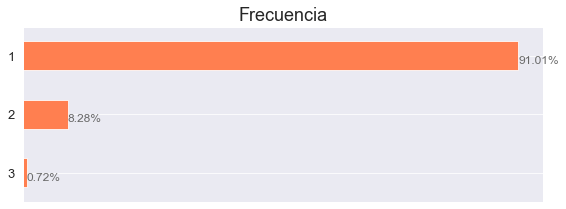

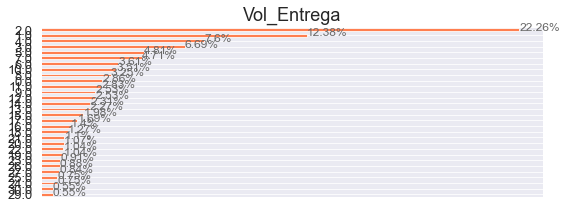

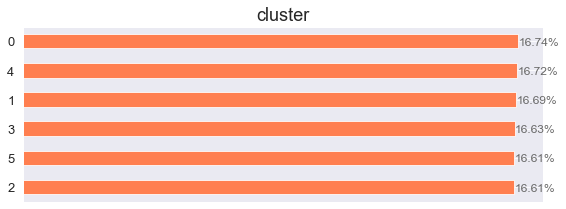

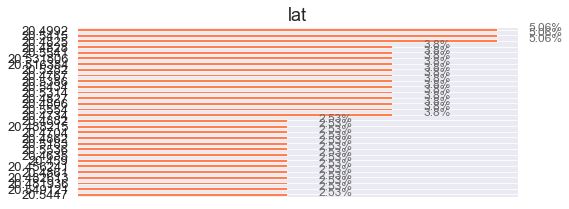

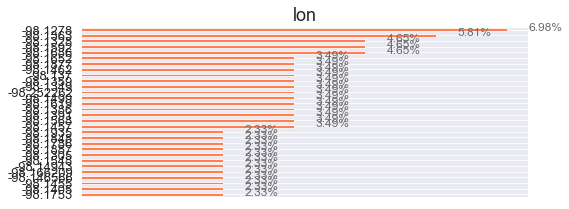

In [58]:
#Inspect value counts for each attribute
for col in df[df.columns.difference(['Id_Cliente', 'id_Agencia'])]:

    ax = df[col].value_counts().head(30).plot(kind='barh', figsize=(8,3),
                                            color="coral", fontsize=13);
    ax.set_alpha(0.8)
    ax.set_title(col, fontsize=18)
    #ax.set_xlabel("%s: %f " % ([col]),fontsize=18);
   
    ax.set_xticks([])

    # create a list to collect the plt.patches data
    totals = []

    # find the values and append to list
    for i in ax.patches:
        totals.append(i.get_width())

    # set individual bar lables using above list
    total = sum(totals)

    # set individual bar lables using above list
    for i in ax.patches:
        # get_width pulls left or right; get_y pushes up or down
        ax.text(i.get_width()+.3, i.get_y()+.38, \
                str(round((i.get_width()/total)*100, 2))+'%', fontsize=12,
    color='dimgrey')

    # invert for largest on top 
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show();

In [59]:
#preview the unique values from each column 
for col in df[df.columns.difference(['Id_Cliente', 'id_Agencia'])]:
    try:     
        print('\n',"-- %s --" % col,'\n',df[col].unique()[:100]) #if unique values are > 30
    except:
        print('\n',"-- %s --" % col,'\n',df[col].unique())


 -- Frecuencia -- 
 [1 3 2]

 -- Vol_Entrega -- 
 [  2.          17.          15.          19.           6.
  20.          10.          45.          13.          21.
  12.          13.5          7.          11.          14.
  18.33333333  11.5         23.5         14.5         47.5
  16.5         25.          22.5         18.5         23.
  15.5         10.5         28.           9.33333333   3.5
  43.           8.5         21.66666667  14.33333333   5.
   4.          36.           7.5          9.           4.5
   6.5         35.5          9.5         30.5         19.5
  31.           5.5          3.          18.          25.5
  17.5         34.5          8.          21.5         20.5
  22.          39.           1.          28.5         24.5
  29.          16.          26.          31.5         12.66666667
  10.66666667  14.66666667  15.33333333  17.66666667  30.
  29.5          6.33333333  41.5          0.          27.5
  24.          53.          27.          12.5         42.
  57.

Techniques applied for our Imbalanced Class

Resample the training set
Oversampling
Undersampling
Repeated Stratified Kfold Cross validation
Resample with different ratios
Ensemble different resampled datasets
Use the right evaluation metrics

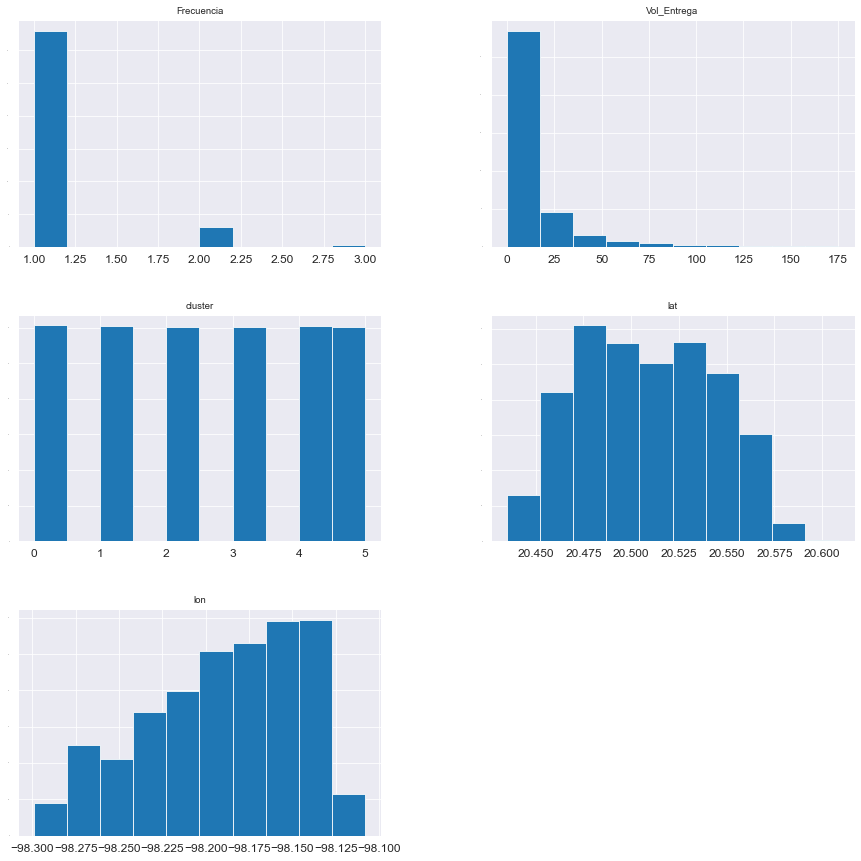

In [79]:
#Visualize the data distribution 
df[df.columns.difference(['Id_Cliente', 'id_Agencia'])].hist(sharex=False, sharey=False, xlabelsize=12, ylabelsize=1,figsize=(15, 15));

In [61]:
# load data set 
y = df.cluster
X = df.drop(['cluster'], axis = 1)
# split into train/test sets 
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=2)
train_0, train_1 = len(y_train[y_train==0]), len(y_train[y_train==1])
test_0, test_1 = len(y_test[y_test==0]), len(y_test[y_test==1])
print('Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))

# split into train/test sets with same class ratio 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=2, stratify=y)
train_0, train_1 = len(y_train[y_train==0]), len(y_train[y_train==1])
test_0, test_1 = len(y_test[y_test==0]), len(y_test[y_test==1])
print('Stratified Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))

Train: 0=313, 1=294, Test: 0=294, 1=311
Stratified Train: 0=303, 1=302, Test: 0=304, 1=303


In [63]:
#Create functions to load data, split traind & test data and time execution

def load_data(file_name):   
    import pandas as pd
    df = pd.read_csv(file_name)
    y = df.cluster
    X = df.drop(['cluster'], axis = 1)
    return X, y

def train_test_dist(X, y):
    train_0, train_1 = len(y_train[y_train==0]), len(y_train[y_train==1])
    test_0, test_1 = len(y_test[y_test==0]), len(y_test[y_test==1])
    print('Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))
    
def split_train_test(X, y):
    X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=2, stratify = y )
    return X_train, X_test, y_train, y_test 

start = time.time()
def exec_time():
    execution_time = time.time() - start
    print('Execution time', time.strftime("%H:%M:%S", time.gmtime(execution_time)))

exec_time()

Execution time 00:00:00


In [64]:
#Calculate prevalence
def calc_prevalence(y_test):
    return (sum(y_test)/len(y_test))
#Calculate specificity
def calc_specificity(y_test, predictions, thresh):
    # calculates specificity
    return sum((predictions < thresh) & (y_test == 0)) /sum(y_test ==0)

#Calculate and print scores        
def print_scores(y_test, y_pred):
    from sklearn.metrics import accuracy_score 
    from sklearn.metrics import precision_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import f1_score
    from sklearn.metrics import mean_squared_error  
    from sklearn.metrics import r2_score
    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import auc
    from sklearn.metrics import classification_report
    from sklearn.metrics import roc_curve
    from sklearn.metrics import precision_score       
    print("Accuracy: {}".format((accuracy_score(y_test, y_pred).round(decimals=4)*100)),'%')
    print("Precision: {}".format(precision_score(y_test, y_pred)))
    print("Recall: {}".format(recall_score(y_test, y_pred)))
    print("F1-score: {}".format(f1_score(y_test, y_pred)))
    print("R2: {}".format(r2_score(y_test, y_pred)))
    print("MSE: {}".format(mean_squared_error(y_test, y_pred)))
    print("Prevalence: {}".format(calc_prevalence(y_pred)))
    print("Specificity: {}".format(calc_specificity(y_test, y_pred, 0.5)))
    print('---------------------------------------------------------------------')
    print('\n','Classification Report:')
    print(classification_report(y_test, y_pred, target_names = ['NO', 'YES']))
    print('---------------------------------------------------------------------')
    # Confusion matrix plot   
    from sklearn.metrics import confusion_matrix
    conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    print('Confusion matrix:\n', conf_mat)
    labels = ['Class 0', 'Class 1']
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    plt.show()

#plot ROC curve
def plot_roc_curve(y_test, model_probs, lblname):
    from sklearn.metrics import precision_recall_curve
    from sklearn.metrics import auc
    from sklearn.metrics import f1_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import precision_score
    auc = roc_auc_score(y_test, model_probs) 
    fpr, tpr, _ = roc_curve(y_test, model_probs)
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label = 'ROC AUC: %.3f' % roc_auc_score(y_test, model_probs).round(decimals=3))
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', alpha=.8)
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xticks(np.arange(0,1.1,0.1))
    plt.yticks(np.arange(0,1.1,0.1))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show();
    
# plot the Precision-Recall Curve
def plot_pr_curve(y_test, y_pred, model_probs, lblname):
    from sklearn.metrics import precision_recall_curve
    from sklearn.metrics import auc
    from sklearn.metrics import f1_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import precision_score
    precision, recall, _ = precision_recall_curve(y_test, model_probs)
    f1, pr_auc = f1_score(y_test, y_pred), auc(recall, precision)
    print('f1=%.3f PR AUC=%.3f' % (f1, pr_auc))
    # calculate the no skill line as the proportion of the positive class
    no_skill = len(y[y==1]) / len(y)
    # plot the no skill precision-recall curve
    plt.plot([0, 1], [no_skill, no_skill],color='red', linestyle='--', label='Random') 
    precision, recall, _ = precision_recall_curve(y_test, model_probs)
    plt.plot(recall, precision, marker='.', label=  'PR AUC: %.3f' % auc(recall, precision).round(decimals=3))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
      # show the legend
    plt.legend()
      # show the plot
    plt.show()
    

#Calculate scores at 25% threshold
def print_scores_thresh(y_test, y_pred):
    print('---------------------------------------------------------------------')
    print('scores with threshold = 0.25')
    print('Accuracy: %.3f'%(accuracy_score(y_test, (LR_probs >= 0.25).astype('int'))))
    print('Recall: %.3f'%(recall_score(y_test, (LR_probs >= 0.25).astype('int'))))
    print('Precision: %.3f'%(precision_score(y_test, (LR_probs >= 0.25).astype('int'))))
    print('F1-score: %.3f'%(f1_score(y_test, (LR_probs >= 0.25).astype('int'))))
    print('AUC: %.3f'%(roc_auc_score(y_test, (LR_probs >= 0.25).astype('int'))))
    print("Prevalence: {}".format(calc_prevalence(LR_probs >= 0.25).astype('int')))
    print("Specificity: {}".format(calc_specificity(y_test, y_pred, 0.25)))
    print('---------------------------------------------------------------------')
    print(classification_report(y_test, (LR_probs >= 0.25).astype('int'), target_names = ['NO', 'YES']))
    display(pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
    print('')

In [69]:

X = df.drop(['cluster'], axis = 1)
y = df.cluster
df
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=2, stratify=y)

#RepeatedStratifiedKFold 
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

counter = Counter(y)
print('Dataset: Class 0=%d, Class 1=%d' % (len(y[y==0]), len(y[y==1])))
print('Train: Class 0=%d, Class 1=%d' % (len(y_train[y_train==0]), len(y_train[y_train==1]))) 
print('Test: Class 0=%d, Class 1=%d' % (len(y_test[y_test==0]), len(y_test[y_test==1])))

print('Relative frequencies of the class (train)')
print(y_train.value_counts(normalize=True))
print('Relative frequencies of the class (test)')
print(y_test.value_counts(normalize=True))

Dataset: Class 0=607, Class 1=605
Train: Class 0=303, Class 1=302
Test: Class 0=304, Class 1=303
Relative frequencies of the class (train)
4    0.167219
0    0.167219
3    0.166667
1    0.166667
5    0.166115
2    0.166115
Name: cluster, dtype: float64
Relative frequencies of the class (test)
0    0.167678
4    0.167126
1    0.167126
5    0.166023
3    0.166023
2    0.166023
Name: cluster, dtype: float64


  Name     Score
0   LR  0.978477
1  KNN  0.997133
2   DT  0.998790
3   RF  0.996863
4  BRF  0.996497
5   BG  0.999070
6  BBG  0.998973
7   GB  0.998790
8   AB  0.499677
9  SVM  0.997687
Execution time 00:00:02


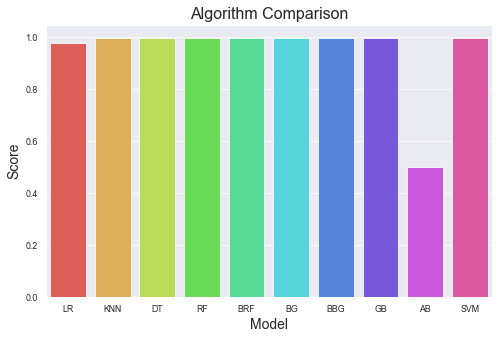

In [70]:
#Let's get a baseline accuracy score from various models 
start = time.time()

models = []
models.append(('LR', LogisticRegression())) 
models.append(('KNN', KNeighborsClassifier())) 
models.append(('DT', DecisionTreeClassifier())) 
models.append(('RF', RandomForestClassifier()))
models.append(('BRF', BalancedRandomForestClassifier()))
models.append(('BG', BaggingClassifier()))
models.append(('BBG', BalancedBaggingClassifier()))
models.append(('GB', GradientBoostingClassifier()))
models.append(('AB', AdaBoostClassifier())) 
#models.append(('XGB', XGBClassifier())) 
models.append(('SVM', SVC()))

# evaluate each model in turn
names = []
scores = []

for name, model in models:
    start= time.time()
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    score = cross_val_score(model, X, y, cv=cv, scoring='accuracy').round(decimals=4)   
    scores.append(score.mean())
    names.append(name)

cross_val = pd.DataFrame({'Name': names,'Score': scores})
print(cross_val)

#create plot
plt.figure(figsize=(8,5))
sns.set_context('paper')
sns.barplot(x = 'Name', y = 'Score',  data = cross_val,
            palette = 'hls',
            capsize = 0.5,             
            saturation = 8,             
            errcolor = 'gray', errwidth = 2,  
            ci = 'sd'   
            )
plt.title('Algorithm Comparison',fontsize=16)
plt.xlabel('Model',fontsize=14)
plt.ylabel('Score',fontsize=14)
plt.show;

execution_time = time.time() - start
print('Execution time', time.strftime("%H:%M:%S", time.gmtime(execution_time)))


# KNeighborsClassifier